# Stock prices, dividends, split-adjustments and identifiers

Copyright 2023, Terence Lim

MIT License

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay
from finds.structured import CRSP, Finder
from finds.recipes import fractiles
from finds.display import show, plot_date
from yahoo import get_price
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(latex=None, ndigits=4)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
imgdir = paths['images']
find = Finder(sql)    # to search identifier lookup tables
ticker = 'AAPL'
find(ticker)

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19821101,APPLE COMPUTER INC,03783310,,AAPL,14593,20040609,11,3,3573,AAPL,0,Q,A,R,7
1,20040610,APPLE COMPUTER INC,03783310,,AAPL,14593,20070110,11,3,3573,AAPL,334111,Q,A,R,7
2,20070111,APPLE INC,03783310,,AAPL,14593,20171227,11,3,3571,AAPL,334111,Q,A,R,7
3,20171228,APPLE INC,03783310,,AAPL,14593,20220331,11,3,3571,AAPL,334220,Q,A,R,7


## Show dividend and split adjustments for AAPL

In [2]:
# Retrieve price history from yahoo finance back to 1980
yahoo_df = get_price(ticker, start_date='19800101', verbose=VERBOSE)
yahoo_df.rename_axis(ticker)

cookies True crumb None
https://finance.yahoo.com/quote/^GSPC


,open,high,low,close,adjClose,volume,retx
AAPL,,,,,,,
19801215,0.12,0.12,0.12,0.12,0.09,175884800.0,NaN
19801216,0.11,0.11,0.11,0.11,0.09,105728000.0,0.916667
19801217,0.12,0.12,0.12,0.12,0.09,86441600.0,1.090909
19801218,0.12,0.12,0.12,0.12,0.09,73449600.0,1.000000
19801219,0.13,0.13,0.13,0.13,0.10,48630400.0,1.083333
...,...,...,...,...,...,...,...
20221223,130.92,132.42,129.64,131.86,131.86,63814900.0,0.997202
20221227,131.38,131.41,128.72,130.03,130.03,69007800.0,0.986122
20221228,129.67,131.03,125.87,126.04,126.04,85438400.0,0.969315


### Get price and distributions history from CRSP

In [3]:
found = find(ticker)      # locate names records by ticker
where = f" where permno = {found['permno'].iloc[-1]}"
dist = sql.read_dataframe(f"select * from {crsp['dist'].key} {where}")
crsp_df = sql.read_dataframe(f"select * from {crsp['daily'].key} {where}")\
             .set_index('date', inplace=False)
crsp_df

,permno,bidlo,askhi,prc,vol,ret,retx,bid,ask,shrout,openprc
date,,,,,,,,,,,
19801212,14593,28.750,28.875,-28.8125,NaN,NaN,NaN,NaN,NaN,55136,NaN
19801215,14593,27.250,27.375,-27.3125,NaN,-0.052061,-0.052061,NaN,NaN,55136,NaN
19801216,14593,25.250,25.375,-25.3125,NaN,-0.073227,-0.073227,NaN,NaN,55136,NaN
19801217,14593,25.875,26.000,-25.9375,NaN,0.024691,0.024691,NaN,NaN,55136,NaN
19801218,14593,26.625,26.750,-26.6875,NaN,0.028916,0.028916,NaN,NaN,55136,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20221223,14593,129.640,132.420,131.8600,63771000.0,-0.002798,-0.002798,NaN,NaN,16319441,130.92
20221227,14593,128.720,131.410,130.0300,69007800.0,-0.013878,-0.013878,NaN,NaN,16319441,131.38
20221228,14593,125.870,131.030,126.0400,85438400.0,-0.030685,-0.030685,NaN,NaN,16319441,129.67


### Merge yahoo and CRSP

In [4]:
df = yahoo_df[['close', 'adjClose']]\
    .join(crsp_df[['prc', 'ret', 'retx', 'vol']]\
          .join(dist[dist['facpr'] != 0.0].set_index('exdt')['facpr'])\
          .join(dist[dist['divamt'] != 0.0].set_index('exdt')['divamt']),
          how='inner')\
    .drop(columns=['vol'])

### Select distribution dates where divamt and facpr are not NA

In [5]:
dist_dates = df.index[:1].append(df.index[~df['divamt'].isna()
                                          | ~df['facpr'].isna()])

### Display cumulative adjustments

AAPL: 19801215-20221230
Cumulative dividend yield 0.2826
Cumulative stock split-adjustment 224.0
Cumulative total stock return multiple 1298.5


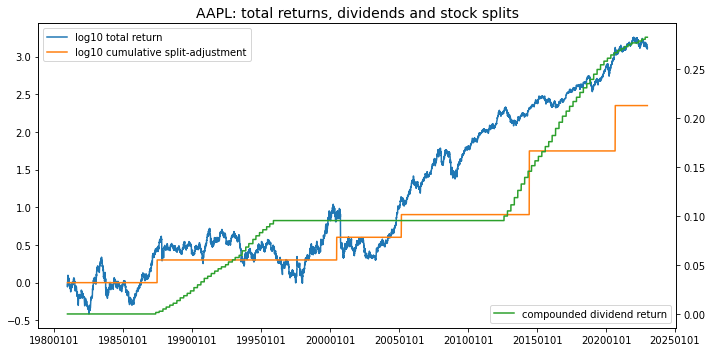

In [6]:
print(f"{ticker}: {min(df.index)}-{max(df.index)}")
print('Cumulative dividend yield',
      ((1+(df['divamt']\
           .fillna(0)\
           .div(df['prc'].add(df['divamt'].fillna(0))))).prod() - 1).round(4))
print('Cumulative stock split-adjustment',
(df['facpr'].fillna(0) + 1).prod())
print('Cumulative total stock return multiple',
      ((df['ret'].fillna(0) + 1).prod()).round(1))

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
plot_date(np.log10((df[['ret']].fillna(0) + 1).cumprod()
                   .join((df[['facpr']].fillna(0)+1).cumprod())),
          (1+(df['divamt'].fillna(0)\
              .div(df['prc'].abs().add(df['divamt'].fillna(0))))).cumprod()-1,
          legend1=['log10 total return', 'log10 cumulative split-adjustment'],
          legend2=['compounded dividend return'],
          loc2='lower right',
          fontsize=10,
          ax=ax,
          title=ticker + ': total returns, dividends and stock splits')
plt.tight_layout()
plt.savefig(imgdir / 'splits.jpg')

## Reconcile CRSP and YAHOO adjustments

CRSP 
- prc: market closing price (negative if closing midquote)
- ret: total daily holding return
- retx: daily capital appreciation return
- facpr: factor to split-adjust price prior to ex-date
- divamt: dividend amount on ex-date

YAHOO
- close: split-adjusted price
- adjClose: split-adjust price, capital appreciation only (exclude dividend)

reconcile Yahoo and CRSP
- price: CRSP price adjusted by cumulative split factor
- adjprice: CRSP split-adjusted price excluding dividends

In [7]:
# Cumulate factor to adjust pre-split prices prior to ex-date
facpr = (1+df['facpr'].shift(-1)).sort_index(ascending=False)\
                                 .cumprod()\
                                 .fillna(method='ffill').fillna(1)

# Split-adjust CRSP market price by cumulative factor
df['price'] = df['prc'].abs().div(facpr)
                                                          
# Reduce CRSP split-adjusted price by dividend income
adjret = (1+df['retx']).cumprod().div(((1+df['ret'])).cumprod())
df['adjprice'] = df['price'].div(adjret) * adjret.iloc[-1] 

In [8]:
# display first five distribution events
show(df.loc[dist_dates].head(5), caption=ticker, **SHOW)

,close,adjClose,prc,ret,retx,facpr,divamt,price,adjprice
AAPL,,,,,,,,,
19801215,0.12,0.09,-27.3125,-0.0521,-0.0521,NaN,NaN,0.1219,0.0948
19870511,0.34,0.27,77.0000,-0.0238,-0.0253,NaN,0.12,0.3438,0.2678
19870616,0.37,0.29,41.5000,0.0573,0.0573,1.0,NaN,0.3705,0.2887
19870810,0.43,0.34,48.2500,0.0389,0.0376,NaN,0.06,0.4308,0.3361
19871117,0.31,0.24,35.0000,-0.0454,-0.0476,NaN,0.08,0.3125,0.2443


In [9]:
# display 1995-2013 distribution events
show(df.loc[dist_dates[(dist_dates>19950816) & (dist_dates<20130207)]], **SHOW)

,close,adjClose,prc,ret,retx,facpr,divamt,price,adjprice
19951121,0.34,0.29,38.625,0.0031,0.0000,NaN,0.12,0.3449,0.2939
20000621,0.99,0.85,55.625,0.0988,0.0988,1.0,NaN,0.9933,0.8466
20050228,1.60,1.37,44.860,0.0082,0.0082,1.0,NaN,1.6021,1.3655
20120809,22.17,18.98,620.730,0.0057,0.0014,NaN,2.65,22.1689,18.9754
20121107,19.93,17.14,558.002,-0.0381,-0.0426,NaN,2.65,19.9286,17.1388


In [10]:
# display last five distribution events
show(df.loc[dist_dates].tail(10), **SHOW)

,close,adjClose,prc,ret,retx,facpr,divamt,price,adjprice
20200807,111.11,109.61,444.45,-0.0227,-0.0245,NaN,0.820,111.1125,109.6045
20200831,129.04,127.29,129.04,0.0339,0.0339,3.0,NaN,129.0400,127.2887
20201106,118.69,117.28,118.69,-0.0011,-0.0029,NaN,0.205,118.6900,117.2813
20210205,136.76,135.34,136.76,-0.0031,-0.0046,NaN,0.205,136.7600,135.3396
20210507,130.21,129.08,130.21,0.0053,0.0036,NaN,0.220,130.2100,129.0752
20210806,146.14,145.08,146.14,-0.0048,-0.0063,NaN,0.220,146.1400,145.0845
20211105,151.28,150.41,151.28,0.0036,0.0021,NaN,0.220,151.2800,150.4057
20220506,157.28,156.80,157.28,0.0047,0.0033,NaN,0.230,157.2800,156.8000
20220805,165.35,165.08,165.35,-0.0014,-0.0028,NaN,0.230,165.3500,165.0748
20221104,138.38,138.38,138.38,-0.0019,-0.0036,NaN,0.230,138.3800,138.3800
